In [31]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import itertools
import pylab as pl
from sklearn import mixture
from sklearn.mixture import GaussianMixture

sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (15,15)

In [32]:
# read data
all_data = pd.read_csv("blood_test.txt")

# set labale addicted to data
def SetLabel(row):
    if row['drinks'] > 5 :
        return 1
    return 0

all_data['addicted'] = all_data.apply (lambda row: SetLabel(row), axis=1)

# seperate test and train data
train_data = all_data.loc[all_data['selector'] == 1]
train_data = train_data.drop('selector', axis=1)

test_data = all_data.loc[all_data['selector'] == 2]
test_data = test_data.drop('selector', axis=1)

# shffule data 
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

test_data_labels = test_data["addicted"]
test_data = test_data.drop('addicted', axis=1)

In [33]:
#pdf of the multivariate normal distribution
def NormalMultivariate(x, d, mean, covariance):
    x_m = x - mean
    seg_1 = np.sqrt((2 * np.pi)**(d/2) * np.linalg.det(covariance))
    return (1. / seg_1) * np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2)

In [34]:
PlotIndex = 1
# Function to evalaute test data based on given prior and cost values 
# and normal distribution of each class 
def Evaluate(test_data,addicted_mean,addicted_covariance,not_addicted_mean,not_addicted_covariance,count,P0=0.5,P1=0.5,l12=1,l21=1):
    global PlotIndex
    Equal = 0
    #Confusion Matrix array
    CM = np.full((2,2),0, dtype = np.uint8)
    
    # select each test data
    for test in range(0,len(test_data)) :
        x = np.array(test_data.loc[test])
        y = test_data_labels.loc[test]

        # pmf of normal distribution of each class
        p1= NormalMultivariate(x,len(x),addicted_mean,addicted_covariance)
        p0= NormalMultivariate(x,len(x),not_addicted_mean,not_addicted_covariance)
        
        y_predict = 0
        
        # prediction rule 
        if p1*l21*P1 > p0*l12*P0 :
            y_predict = 1

        if p0!=p1 :
            CM[y_predict][y]+= 1
        else :
            if p1 != 0 :
                CM[1][y]+= 1
            else :
                Equal += 1
    #Accuracy
    acc  = round((CM[0][0]+CM[1][1])/(CM[0][0]+CM[1][1]+CM[1][0]+CM[0][1])*100,2)
    
    #plotting
    if PlotIndex > 3 :
        PlotIndex = 1
    plt.subplot(3,1,PlotIndex)
    PlotIndex +=1
    sns.heatmap(CM, annot=True, cmap='Blues',fmt="g")
    plt.title("Confusion Matrix for indicating errors | Random Samples: {0} | Accuracy: {1}%".format(count,acc))
    return acc

In [35]:
# all Features
Features = ["mcv","alkphos","sgpt","sgot","gammagt"]

# store results
BestFeatures = []
BestAcc = []
i = 0

# select 100 random samples
train_data_ = train_data.sample(100)
not_addicted_sample = train_data_.loc[train_data['addicted'] == 0].drop('addicted', axis=1)
addicted_sample = train_data_.loc[train_data['addicted'] == 1].drop('addicted', axis=1)

# calculate accuracy of all combinations of two features
for two_parameter in itertools.combinations(Features, 2):
    two_parameter = list(two_parameter)
    
    # estimate parameters
    n_mean = np.array(not_addicted_sample[two_parameter].mean())
    n_cov = np.matrix(not_addicted_sample[two_parameter].cov())
    
    P0 = not_addicted_sample.shape[0]/train_data_.shape[0]
    P1 = addicted_sample.shape[0]/train_data_.shape[0]
    
    a_mean = np.array(addicted_sample[two_parameter].mean())
    a_cov = np.matrix(addicted_sample[two_parameter].cov())

    #evaluate the estimated features
    acc = Evaluate(test_data[two_parameter],a_mean,a_cov,n_mean,n_cov,i,P0,P1,3,2)
    
    BestFeatures.append(two_parameter)
    BestAcc.append(acc)
    i+=1
    
    plt.clf()

# print results
for i in range(len(BestAcc)):
    print("Accuracy: {0}  \t  Parameters: {1}".format(round(BestAcc[i],2),BestFeatures[i]))
selected = BestFeatures[BestAcc.index(max(BestAcc))]

Accuracy: 76.5  	  Parameters: ['mcv', 'alkphos']
Accuracy: 75.0  	  Parameters: ['mcv', 'sgpt']
Accuracy: 74.0  	  Parameters: ['mcv', 'sgot']
Accuracy: 74.5  	  Parameters: ['mcv', 'gammagt']
Accuracy: 73.5  	  Parameters: ['alkphos', 'sgpt']
Accuracy: 73.0  	  Parameters: ['alkphos', 'sgot']
Accuracy: 74.0  	  Parameters: ['alkphos', 'gammagt']
Accuracy: 72.5  	  Parameters: ['sgpt', 'sgot']
Accuracy: 71.5  	  Parameters: ['sgpt', 'gammagt']
Accuracy: 71.5  	  Parameters: ['sgot', 'gammagt']


<Figure size 1080x1080 with 0 Axes>

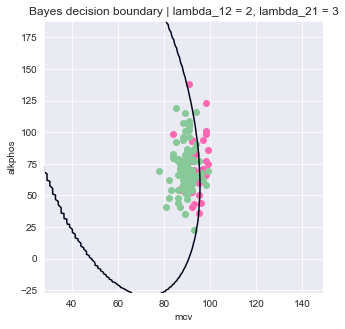

In [36]:
# estimate parameters for selected features
n_mean = np.array(not_addicted_sample[selected].mean())
n_cov = np.matrix(not_addicted_sample[selected].cov())

P0 = not_addicted_sample.shape[0]/train_data_.shape[0]
P1 = addicted_sample.shape[0]/train_data_.shape[0]

a_mean = np.array(addicted_sample[selected].mean())
a_cov = np.matrix(addicted_sample[selected].cov())

train = np.r_[np.array(not_addicted_sample[selected]),np.array(addicted_sample[selected]),]



def g0(x0, x1,p,l):
    res = []
    for _ in np.array(list(zip(x0, x1))) :
        res.append(NormalMultivariate(_,len(_),n_mean,n_cov)*p*l)
    return np.array(res)

def g1(x0, x1,p,l):
    res = []
    for _ in np.array(list(zip(x0, x1))) :
        res.append(NormalMultivariate(_,len(_),a_mean,a_cov)*p*l)
    return np.array(res)



# plotting
X, Y = np.mgrid[train_data[selected[0]].min()-50:train_data[selected[0]].max()+50:100j, train_data[selected[1]].min()-50:train_data[selected[1]].max()+50:100j]
x = X.ravel()
y = Y.ravel()

plt.rcParams["figure.figsize"] = (5,5)
p = (g0(x, y,P0,3) - g1(x, y,P1,2)).reshape(X.shape)

plt.xlabel(selected[0])
plt.ylabel(selected[1])
plt.title("Bayes decision boundary | lambda_12 = 2, lambda_21 = 3")
plt.contour(X, Y, p, levels=[0])
plt.scatter(train_data.loc[train_data['addicted'] == 1][selected[0]], train_data.loc[train_data['addicted'] == 1][selected[1]], color = 'hotpink',label="addicted")
plt.scatter(train_data.loc[train_data['addicted'] == 0][selected[0]], train_data.loc[train_data['addicted'] == 0][selected[1]], color = '#88c999',label="not addicted")

plt.show()